In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
import shutil
import os
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from sklearn import preprocessing
from scipy.stats import zscore
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.datasets import cifar10
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
from skimage import color, exposure, transform

NUM_CLASSES = 26
IMG_SIZE = 200


def preprocess_img_hsv(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img, -1)

    return img


import sys
import cv2

def preprocessing_img_black_and_white(img):
    im_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    skin_ycrcb_mint = np.array((0, 133, 77))
    skin_ycrcb_maxt = np.array((255, 173, 127))
    skin_ycrcb = cv2.inRange(im_ycrcb, skin_ycrcb_mint, skin_ycrcb_maxt)
    return skin_ycrcb

In [3]:
import os

testFiles=[]
trainFiles=[]
for root, dirs, files in os.walk('./data/asl-alphabet/asl_alphabet_train/'):
     for file in files:
            if file.endswith('.jpg'):
                if not file.endswith('_test.jpg'):
                    number=file[1:file.find('.')]
                    if not number.isdigit():
                        continue
                    if(int(number)>50):
                        continue
                file_path = os.path.join(root,file)
                #print(file_path)
                if file.endswith('_test.jpg'):
                    if (not file.startswith('nothing_') and not file.startswith('space_') and not(file.startswith('del_'))):
                        testFiles.append(file_path)
                else:
                    if ((not "nothing" in file) and (not "space" in file) and (not "del" in file)):
                        trainFiles.append(file_path)
testFiles.sort()
trainFiles.sort()
print(len(testFiles))
print(len(trainFiles))

#creating the sample set of 20 test images for each alphabet
import os

testFiles=[]

for root, dirs, files in os.walk('./data/asl-alphabet/asl_alphabet_train/'): #asl_alphabet_test_sample
     for file in files:
            if file.endswith('.jpg'):
                if not file.endswith('_test.jpg'):
                    number=file[1:file.find('.')]
                    if not number.isdigit():
                        continue
                    if((int(number)<=50) or int(number)>60):
                        continue
                file_path = os.path.join(root,file)
                #print(file_path)
                if (not file.startswith('nothing_') and not file.startswith('space_') and not(file.startswith('del_'))):
                    testFiles.append(file_path)
                    
testFiles.sort()
trainFiles.sort()
print(len(testFiles))
print(len(trainFiles))

0
1300
260
1300


In [4]:
from skimage import io
import numpy as np
j=0
# numpy_array_train = np.empty([78000,200,200,3])
x_train = np.empty([1300,200,200])
y_train = []
y_train_for_df = []
alphabet_array = []
alphabet_array.append('A')
alphabet_array.append('B')
alphabet_array.append('C')
alphabet_array.append('D')
alphabet_array.append('E')
alphabet_array.append('F')
alphabet_array.append('G')
alphabet_array.append('H')
alphabet_array.append('I')
alphabet_array.append('J')
alphabet_array.append('K')
alphabet_array.append('L')
alphabet_array.append('M')
alphabet_array.append('N')
alphabet_array.append('O')
alphabet_array.append('P')
alphabet_array.append('Q')
alphabet_array.append('R')
alphabet_array.append('S')
alphabet_array.append('T')
alphabet_array.append('U')
alphabet_array.append('V')
alphabet_array.append('W')
alphabet_array.append('X')
alphabet_array.append('Y')
alphabet_array.append('Z')
k=0
print(len(trainFiles))
for i in trainFiles:    
    x_train[j]=preprocessing_img_black_and_white(io.imread(i))
    j=j+1
    y_train.append(alphabet_array[k])
    if (j%50) == 0: #j%3000 for complete
        k=k+1

print(len(x_train))
print(x_train[1299])

1300
1300
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0. 255. ... 255.   0.   0.]
 ...
 [  0.   0. 255. ...   0. 255.   0.]
 [  0.   0.   0. ... 255.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [5]:
from skimage import io
import numpy as np
j=0
k=0
y_test = []
x_test = np.empty([260,200,200]) 

for i in testFiles:    
    x_test[j]=preprocessing_img_black_and_white(io.imread(i))
    j=j+1
    y_test.append(alphabet_array[k])
    if (j%10) == 0:
        k=k+1


x_test.shape

(260, 200, 200)

In [6]:
y_train_np=np.asarray(y_train)
y_test_np = np.asarray(y_test)
print(x_train.shape)
print(x_test.shape)
print(y_train_np.shape)
print(y_test_np.shape)

(1300, 200, 200)
(260, 200, 200)
(1300,)
(260,)


In [7]:
# x_train = x_train.reshape(x_train.shape[0], 200, 200, 1)
# x_test = x_test.reshape(x_test.shape[0], 200, 200, 1)
x_train = x_train.reshape(len(x_train),-1)
x_test = x_test.reshape(len(x_test),-1)
print(x_train.shape)
print(x_test.shape)
print(y_train_np.shape)
print(y_test_np.shape)

(1300, 40000)
(260, 40000)
(1300,)
(260,)


In [8]:
print(x_train.dtype)
print(x_test.dtype)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


float64
float64


In [9]:
# normalize the data values to the range [0, 1]
x_train /= 255
x_test /= 255

In [10]:
#Label Encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train_np)
df_y_train = pd.DataFrame(y_train, columns=['one_hot_encoded'])
encode_text_dummy(df_y_train, 'one_hot_encoded')
y_train = df_y_train.values


y_test = le.fit_transform(y_test_np)
df_y_test = pd.DataFrame(y_test, columns=['one_hot_encoded'])
encode_text_dummy(df_y_test, 'one_hot_encoded')
y_test = df_y_test.values

In [11]:
# x_train=x_train.reshape(len(x_train),-1)
# x_test=x_test.reshape(len(x_test),-1)
# y_train_np=np.asarray(y_train)
# y_test_np = np.asarray(y_test)
# print(x_train.shape)
# print(x_test.shape)
# print(y_train_np.shape)
# print(y_test_np.shape)

In [12]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)
    model = Sequential()
    model.add(Dense(100, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(60, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

print('Training finished...Loading the best model')  
print()
model.load_weights('best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

0
Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 2s - loss: 2.1674 - val_loss: 2.0115
Epoch 2/100
 - 1s - loss: 0.4539 - val_loss: 1.9402
Epoch 3/100
 - 1s - loss: 0.0738 - val_loss: 2.1009
Epoch 4/100
 - 1s - loss: 0.0209 - val_loss: 1.9474
Epoch 5/100
 - 1s - loss: 0.0057 - val_loss: 1.8954
Epoch 6/100
 - 1s - loss: 0.0035 - val_loss: 1.9534
Epoch 7/100
 - 1s - loss: 0.0024 - val_loss: 1.9483
Epoch 8/100
 - 1s - loss: 0.0019 - val_loss: 2.0013
Epoch 9/100
 - 1s - loss: 0.0015 - val_loss: 1.9784
Epoch 10/100
 - 1s - loss: 0.0012 - val_loss: 2.0382
Epoch 00010: early stopping
1
Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 2s - loss: 2.1044 - val_loss: 2.0211
Epoch 2/100
 - 1s - loss: 0.4565 - val_loss: 1.7156
Epoch 3/100
 - 1s - loss: 0.0910 - val_loss: 1.5583
Epoch 4/100
 - 1s - loss: 0.0189 - val_loss: 1.6981
Epoch 5/100
 - 1s - loss: 0.0085 - val_loss: 1.6842
Epoch 6/100
 - 1s - loss: 0.0043 - val_loss: 1.7295
Epoch 7/100
 - 1s - loss: 0.0027 - val_lo

<h4>Confusion Matrix: Neural Network</h4>

Plotting confusion matrix


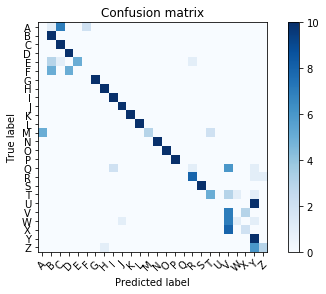

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        10
          1       0.53      1.00      0.69        10
          2       0.56      1.00      0.71        10
          3       0.67      1.00      0.80        10
          4       1.00      0.50      0.67        10
          5       0.00      0.00      0.00        10
          6       1.00      1.00      1.00        10
          7       0.91      1.00      0.95        10
          8       0.83      1.00      0.91        10
          9       0.91      1.00      0.95        10
         10       1.00      1.00      1.00        10
         11       1.00      1.00      1.00        10
         12       1.00      0.30      0.46        10
         13       1.00      1.00      1.00        10
         14       1.00      1.00      1.00        10
         15       1.00      1.00      1.00        10
         16       0.00      0.00      0.00        10
         17       0.80      0.80      0.80   

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
#Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, alphabet_array)
plt.show()

print(classification_report(y_true, pred))
print("Final accuracy :", metrics.accuracy_score(y_true, pred))

In [14]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)
    model = Sequential()
    model.add(Dense(200, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(97, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

print('Training finished...Loading the best model')  
print()
model.load_weights('best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

0
Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 4s - loss: 1.9140 - val_loss: 2.1108
Epoch 2/100
 - 3s - loss: 0.3403 - val_loss: 1.3700
Epoch 3/100
 - 3s - loss: 0.0461 - val_loss: 1.6873
Epoch 4/100
 - 3s - loss: 0.0093 - val_loss: 1.3085
Epoch 5/100
 - 3s - loss: 0.0019 - val_loss: 1.3107
Epoch 6/100
 - 3s - loss: 9.6113e-04 - val_loss: 1.3834
Epoch 7/100
 - 3s - loss: 6.3203e-04 - val_loss: 1.4069
Epoch 8/100
 - 3s - loss: 4.7865e-04 - val_loss: 1.3439
Epoch 9/100
 - 3s - loss: 3.6514e-04 - val_loss: 1.3631
Epoch 00009: early stopping
1
Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 4s - loss: 2.4081 - val_loss: 1.7859
Epoch 2/100
 - 3s - loss: 0.5947 - val_loss: 1.4724
Epoch 3/100
 - 3s - loss: 0.1064 - val_loss: 1.2993
Epoch 4/100
 - 3s - loss: 0.0256 - val_loss: 1.2871
Epoch 5/100
 - 3s - loss: 0.0073 - val_loss: 1.3113
Epoch 6/100
 - 3s - loss: 0.0101 - val_loss: 1.3488
Epoch 7/100
 - 3s - loss: 0.0023 - val_loss: 1.2716
Epoch 8/100
 - 3s - loss: 

Plotting confusion matrix


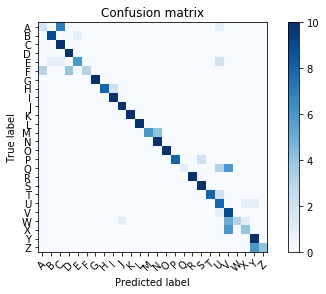

             precision    recall  f1-score   support

          0       0.40      0.20      0.27        10
          1       0.90      0.90      0.90        10
          2       0.56      1.00      0.71        10
          3       0.71      1.00      0.83        10
          4       0.86      0.60      0.71        10
          5       1.00      0.30      0.46        10
          6       1.00      1.00      1.00        10
          7       1.00      0.80      0.89        10
          8       0.83      1.00      0.91        10
          9       0.91      1.00      0.95        10
         10       1.00      1.00      1.00        10
         11       1.00      1.00      1.00        10
         12       1.00      0.60      0.75        10
         13       0.71      1.00      0.83        10
         14       1.00      1.00      1.00        10
         15       1.00      0.80      0.89        10
         16       1.00      0.10      0.18        10
         17       1.00      1.00      1.00   

In [15]:
#Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, alphabet_array)
plt.show()

print(classification_report(y_true, pred))
print("Final accuracy: :", metrics.accuracy_score(y_true, pred))

In [16]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)
    model = Sequential()
    model.add(Dense(200, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(97, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

print('Training finished...Loading the best model')  
print()
model.load_weights('best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

0
Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 4s - loss: 1.7811 - val_loss: 1.4324
Epoch 2/100
 - 2s - loss: 0.1332 - val_loss: 1.0700
Epoch 3/100
 - 3s - loss: 0.0382 - val_loss: 1.4339
Epoch 4/100
 - 3s - loss: 0.0349 - val_loss: 1.5827
Epoch 5/100
 - 3s - loss: 0.0157 - val_loss: 1.2320
Epoch 6/100
 - 3s - loss: 0.0013 - val_loss: 1.2770
Epoch 7/100
 - 3s - loss: 5.1881e-04 - val_loss: 1.2609
Epoch 00007: early stopping
1
Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 4s - loss: 1.7584 - val_loss: 1.8903
Epoch 2/100
 - 3s - loss: 0.1921 - val_loss: 1.1578
Epoch 3/100
 - 3s - loss: 0.0317 - val_loss: 1.1680
Epoch 4/100
 - 3s - loss: 0.0085 - val_loss: 1.2532
Epoch 5/100
 - 3s - loss: 0.0024 - val_loss: 1.1286
Epoch 6/100
 - 3s - loss: 0.0015 - val_loss: 1.1694
Epoch 7/100
 - 3s - loss: 0.0011 - val_loss: 1.1680
Epoch 8/100
 - 3s - loss: 8.9707e-04 - val_loss: 1.1898
Epoch 9/100
 - 3s - loss: 7.1950e-04 - val_loss: 1.1896
Epoch 10/100
 - 3s - loss: 5.9

Plotting confusion matrix


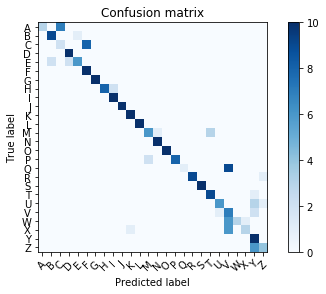

             precision    recall  f1-score   support

          0       1.00      0.30      0.46        10
          1       0.82      0.90      0.86        10
          2       0.22      0.20      0.21        10
          3       0.83      1.00      0.91        10
          4       0.86      0.60      0.71        10
          5       0.56      1.00      0.71        10
          6       1.00      1.00      1.00        10
          7       1.00      0.80      0.89        10
          8       0.83      1.00      0.91        10
          9       1.00      1.00      1.00        10
         10       0.91      1.00      0.95        10
         11       1.00      1.00      1.00        10
         12       0.75      0.60      0.67        10
         13       0.91      1.00      0.95        10
         14       1.00      1.00      1.00        10
         15       1.00      0.80      0.89        10
         16       1.00      0.10      0.18        10
         17       1.00      0.90      0.95   

In [17]:
#Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, alphabet_array)
plt.show()

print(classification_report(y_true, pred))
print("Final accuracy: ", metrics.accuracy_score(y_true, pred))

In [18]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)
    model = Sequential()
    model.add(Dense(400, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(656, activation='relu'))
    model.add(Dense(379, activation='relu'))
    model.add(Dense(147, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

print('Training finished...Loading the best model')  
print()
model.load_weights('best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

0
Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 8s - loss: 1.7679 - val_loss: 1.3545
Epoch 2/100
 - 6s - loss: 0.1507 - val_loss: 1.2178
Epoch 3/100
 - 6s - loss: 0.0501 - val_loss: 0.9817
Epoch 4/100
 - 7s - loss: 0.0271 - val_loss: 1.4126
Epoch 5/100
 - 7s - loss: 0.0310 - val_loss: 1.3008
Epoch 6/100
 - 7s - loss: 0.0132 - val_loss: 1.0001
Epoch 7/100
 - 7s - loss: 0.0214 - val_loss: 1.7342
Epoch 8/100
 - 6s - loss: 0.0931 - val_loss: 1.6925
Epoch 00008: early stopping
1
Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 8s - loss: 2.1431 - val_loss: 1.5371
Epoch 2/100
 - 7s - loss: 0.2064 - val_loss: 0.9815
Epoch 3/100
 - 6s - loss: 0.0360 - val_loss: 1.1268
Epoch 4/100
 - 6s - loss: 0.0406 - val_loss: 1.1271
Epoch 5/100
 - 7s - loss: 0.0081 - val_loss: 1.1512
Epoch 6/100
 - 7s - loss: 0.0123 - val_loss: 1.2353
Epoch 7/100
 - 6s - loss: 0.0047 - val_loss: 1.2579
Epoch 00007: early stopping
2
Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 8s

Plotting confusion matrix


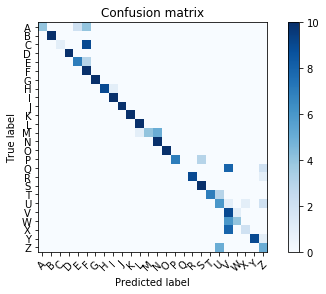

             precision    recall  f1-score   support

          0       1.00      0.40      0.57        10
          1       1.00      1.00      1.00        10
          2       1.00      0.10      0.18        10
          3       1.00      1.00      1.00        10
          4       0.78      0.70      0.74        10
          5       0.38      1.00      0.56        10
          6       1.00      1.00      1.00        10
          7       1.00      0.90      0.95        10
          8       0.91      1.00      0.95        10
          9       1.00      1.00      1.00        10
         10       1.00      1.00      1.00        10
         11       0.91      1.00      0.95        10
         12       1.00      0.40      0.57        10
         13       0.67      1.00      0.80        10
         14       1.00      1.00      1.00        10
         15       1.00      0.70      0.82        10
         16       0.00      0.00      0.00        10
         17       1.00      0.90      0.95   

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
#Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, alphabet_array)
plt.show()

print(classification_report(y_true, pred))
print("Final accuracy :", metrics.accuracy_score(y_true, pred))